Train acc  : 0.967
Valid acc  : 0.933
Test  acc  : 0.967


/tmp/ipython-input-523335770.py:159: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


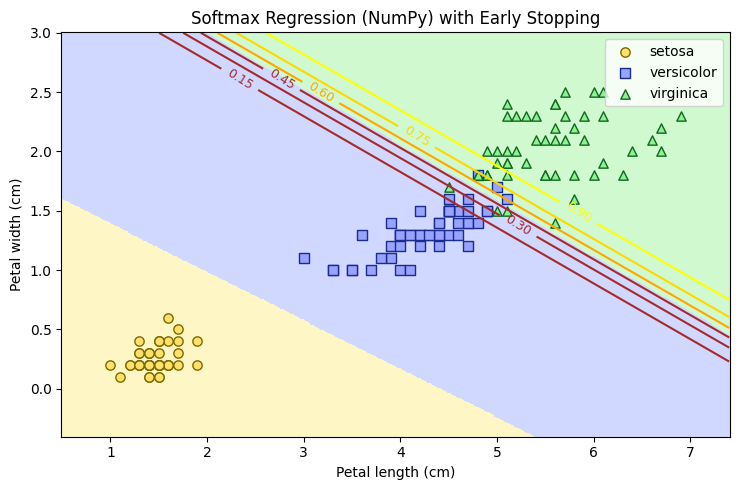

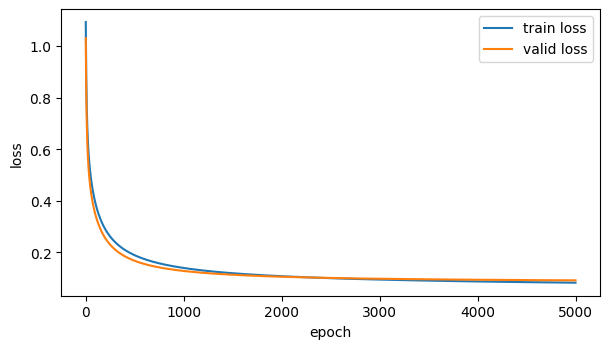

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris  # 데이터 '로딩'만 사용

# --- 0) Utilities ---
def one_hot(y, K):
    Y = np.zeros((y.size, K))
    Y[np.arange(y.size), y] = 1.0
    return Y

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)  # 수치 안정화
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def cross_entropy(P, Y):
    # 작은 epsilon으로 log(0) 방지
    eps = 1e-12
    return -np.mean(np.sum(Y * np.log(P + eps), axis=1))

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# --- 1) Load & split ---
rng = np.random.default_rng(42)

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values  # (150,2)
y = iris.target.values                                          # (150,)
classes = iris.target_names
K = len(classes)

# Train/Val/Test = 60%/20%/20%
n = len(y)
perm = rng.permutation(n)
n_tr, n_val = int(0.6*n), int(0.2*n)
idx_tr = perm[:n_tr]
idx_val = perm[n_tr:n_tr+n_val]
idx_te = perm[n_tr+n_val:]

X_tr, y_tr = X[idx_tr], y[idx_tr]
X_val, y_val = X[idx_val], y[idx_val]
X_te,  y_te  = X[idx_te],  y[idx_te]

# 표준화(훈련 통계로만)
mu = X_tr.mean(axis=0, keepdims=True)
sd = X_tr.std(axis=0, keepdims=True) + 1e-8
X_tr_s = (X_tr - mu)/sd
X_val_s = (X_val - mu)/sd
X_te_s  = (X_te  - mu)/sd

# 바이어스를 위해 1 추가
def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

X_tr_b = add_bias(X_tr_s)
X_val_b = add_bias(X_val_s)
X_te_b  = add_bias(X_te_s)

Y_tr = one_hot(y_tr, K)
Y_val = one_hot(y_val, K)

# --- 2) Train: batch GD + early stopping ---
d = X_tr_b.shape[1]   # 2 features + bias = 3
W = rng.normal(scale=0.01, size=(d, K))  # 초기 가중치

lr = 0.1
max_epochs = 5000
patience = 200
l2 = 0.0  # 필요하면 >0 로 조정

best_W = W.copy()
best_val = np.inf
streak = 0
history = {"tr_loss": [], "val_loss": []}

for epoch in range(1, max_epochs+1):
    # forward
    P_tr = softmax(X_tr_b @ W)
    loss_tr = cross_entropy(P_tr, Y_tr) + 0.5*l2*np.sum(W[:-1]**2)  # bias 제외 L2
    # grad
    G = (X_tr_b.T @ (P_tr - Y_tr)) / X_tr_b.shape[0]
    G[:-1] += l2 * W[:-1]  # bias 제외 L2
    # step
    W -= lr * G

    # validation
    P_val = softmax(X_val_b @ W)
    loss_val = cross_entropy(P_val, Y_val)

    history["tr_loss"].append(loss_tr)
    history["val_loss"].append(loss_val)

    # early stopping
    if loss_val + 1e-8 < best_val:
        best_val = loss_val
        best_W = W.copy()
        streak = 0
    else:
        streak += 1
        if streak >= patience:
            # print(f"Early stop @ {epoch}, best val loss = {best_val:.4f}")
            break

W = best_W  # 베스트 가중치로 복원

# --- 3) Report accuracy ---
def predict(Xb, W):
    return np.argmax(softmax(Xb @ W), axis=1)

y_tr_pred  = predict(X_tr_b, W)
y_val_pred = predict(X_val_b, W)
y_te_pred  = predict(X_te_b,  W)

print(f"Train acc  : {accuracy(y_tr, y_tr_pred):.3f}")
print(f"Valid acc  : {accuracy(y_val, y_val_pred):.3f}")
print(f"Test  acc  : {accuracy(y_te,  y_te_pred):.3f}")

# --- 4) Plot decision regions + probability contours ---
plt.figure(figsize=(7.5, 5))

# 원본 스케일에서 그리드 만들기
x1_min, x1_max = X[:,0].min()-0.5, X[:,0].max()+0.5
x2_min, x2_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 400),
                       np.linspace(x2_min, x2_max, 400))
grid_raw = np.c_[xx1.ravel(), xx2.ravel()]
grid_s = (grid_raw - mu)/sd
grid_b = add_bias(grid_s)

probs = softmax(grid_b @ W)             # (N, K)
Z = np.argmax(probs, axis=1).reshape(xx1.shape)

# 배경(결정영역)
from matplotlib.colors import ListedColormap
cmap_bg = ListedColormap(["#fff2a8", "#b8c3ff", "#b9f7b8"])  # setosa / versicolor / virginica
plt.pcolormesh(xx1, xx2, Z, shading="auto", cmap=cmap_bg, alpha=0.65)

# 컨투어(virginica 확률)
p_vir = probs[:, 2].reshape(xx1.shape)
CS = plt.contour(xx1, xx2, p_vir, levels=[0.15, 0.30, 0.45, 0.60, 0.75, 0.90],
                 colors=["brown","brown","brown","orange","gold","yellow"])
plt.clabel(CS, inline=True, fmt="%.2f", fontsize=9)

# 산점도(원본 스케일 좌표)
markers = ["o", "s", "^"]
edge = ["#7a6a00", "#1a2c8e", "#0f6a1a"]
face  = ["#ffe16b", "#98a2ff", "#8ff098"]
for k in range(K):
    mask = (y == k)
    plt.scatter(X[mask,0], X[mask,1], s=45, marker=markers[k],
                edgecolor=edge[k], facecolor=face[k], linewidth=1.0,
                label=classes[k])

plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.legend()
plt.title("Softmax Regression (NumPy) with Early Stopping")
plt.tight_layout()
plt.show()

# --- 5) Loss curve (옵션) ---
plt.figure(figsize=(6.2,3.6))
plt.plot(history["tr_loss"], label="train loss")
plt.plot(history["val_loss"], label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
plt.show()
